In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import itertools
import warnings

import pandas as pd
import statsmodels.api as sm 

def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

def regress_error(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    output = list(result.params)
    output.extend(list(result.bse))
    return pd.Series(output, ["slope", "intercept", "slope_e", "intercept_e"])

sns.set(style="darkgrid", palette="Set2") 

# Importing multiple plates with different layouts

In [2]:
files = [   
              # control, either -/+ nitrate and mo. good data. 
             ["growth_data/ezRich_NO3_test_060524.txt",
             {"A": "-/-", "B": "-/-", "C": "-/2", "D": "+/3","E": "+/2", "F": "+/1", "G": "+/-", "H": "+/-"},
             [["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]],
             [["A", "B", "C", "D", "E", "F", "G", "H"]],
             {"MG1655": [0, 0]},
              12],       
        ]




for i, file in enumerate(files):

    fname = file[0]
    additive = file[1]
    genotype_col = file[2]
    genotype_row = file[3]
    genotype_combinations = file[4]
    n_replicate = file[5]

    al = pl.DataFrame(additive).transpose(include_header=True)
    if "A" in additive.keys():
        al = al.rename({"column": "Row", "column_0": "Additive"})
    if "1" in additive.keys():
        al = al.rename({"column": "Column", "column_0": "Additive"})
    al = al.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    gl = []
    
    for genotype, idx in genotype_combinations.items():
    
        gl.extend([[genotype, x+y] for x in genotype_row[idx[0]] for y in genotype_col[idx[1]]])

    gl = pl.DataFrame(gl).transpose()
    gl = gl.rename({"column_0": "Genotype", "column_1": "Well"})
    gl = gl.with_columns(Plate = pl.lit(f"Plate {i+1}"))

    if i == 0:    
        df = pl.read_csv(fname, separator="\t") # growth_data/cyrus_mutant_013124.txt
        df = df.with_columns(Plate = pl.lit("Plate 1"))
        df = df.with_columns(N_replicate = n_replicate)
        df = df.drop('T600')

        gdf = gl
        adf = al

    else:
        df_add = pl.read_csv(fname, separator="\t")
        df_add = df_add.with_columns(Plate = pl.lit(f"Plate {i+1}"))
        df_add = df_add.with_columns(N_replicate = n_replicate)
        df_add = df_add.drop('T600')
        df = pl.concat([df, df_add])

        gdf = pl.concat([gdf, gl])
        adf = pl.concat([adf, al])

# time conversion
df = df.with_columns(pl.col("Time").str.to_time("%H:%M:%S"))
df = df.with_columns(df['Time'].dt.hour().cast(pl.Int64) + df['Time'].dt.minute().cast(pl.Int64) / 60 + df['Time'].dt.second() / 3600)

# get minimum OD measured, used to be 1.5
init_df = df.filter(pl.col("Time") > 1).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD")
init_df = init_df.group_by(["Plate", "Well"]).min()

init_df_median = df.filter(pl.col("Time") < 5).sort(by="Time").drop(["Time"]).melt(id_vars=["Plate"], variable_name="Well", value_name="Initial_OD_median")
init_df_median = init_df_median.group_by(["Plate", "Well"]).median()

init_df

# blank_df.head(3)
df.head(3)

Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,…,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,G1,G2,G3,G4,G5,G6,G7,G8,G9,G10,G11,G12,H1,H2,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12,Plate,N_replicate
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i32
0.013611,0.6968,0.6282,0.7496,0.5901,0.5553,0.5908,0.5697,0.5371,0.6035,0.6486,0.6095,0.6363,0.6698,0.6557,0.5565,0.6123,0.576,0.6352,0.5617,0.6075,0.5932,0.6309,0.627,0.5649,0.4666,0.5865,0.5094,0.5342,0.5298,0.5754,0.54,0.5096,0.6701,0.5851,0.6451,0.5424,…,0.5383,0.4946,0.5388,0.4754,0.6717,0.5838,0.5848,0.5086,0.5632,0.6398,0.683,0.537,0.714,0.5693,0.4445,0.7079,0.5661,0.5302,0.5671,0.5813,0.6045,0.6691,0.6222,0.5325,0.606,0.5463,0.5065,0.6421,0.612,0.5912,0.5668,0.7234,0.4211,0.4656,0.5072,"""Plate 1""",12
0.063611,0.6936,0.6282,0.7475,0.5894,0.5611,0.5914,0.5666,0.5396,0.6029,0.6443,0.6076,0.6289,0.6692,0.6596,0.5579,0.6133,0.5758,0.631,0.5604,0.6073,0.5905,0.6276,0.6243,0.5664,0.4627,0.5913,0.506,0.5353,0.5279,0.5806,0.5442,0.5077,0.6731,0.5718,0.6433,0.5439,…,0.537,0.4902,0.54,0.4752,0.6729,0.5818,0.5822,0.5093,0.565,0.6313,0.6788,0.538,0.7134,0.5707,0.443,0.7115,0.5682,0.5248,0.567,0.5818,0.6016,0.6718,0.6201,0.5308,0.6071,0.5461,0.5026,0.6437,0.6081,0.5943,0.5635,0.7225,0.4225,0.4658,0.5046,"""Plate 1""",12
0.113611,0.6927,0.6283,0.7471,0.5863,0.5551,0.5885,0.5744,0.5442,0.5963,0.6469,0.6064,0.6229,0.6657,0.6655,0.5601,0.609,0.5764,0.632,0.5662,0.6113,0.5894,0.6223,0.6258,0.5668,0.4629,0.5873,0.5065,0.5364,0.5275,0.5736,0.5403,0.5156,0.6628,0.5511,0.6446,0.5413,…,0.5362,0.4903,0.5484,0.474,0.6739,0.5813,0.5803,0.5061,0.5646,0.641,0.6671,0.5374,0.717,0.571,0.4461,0.7089,0.5616,0.5251,0.5657,0.5801,0.5874,0.6695,0.6209,0.5295,0.6038,0.5529,0.4999,0.6415,0.6062,0.5886,0.5613,0.7249,0.4192,0.4694,0.5064,"""Plate 1""",12


In [3]:
# melt to experiments
mdf = df.melt(id_vars=["Time", "Plate", "N_replicate"], variable_name="Well", value_name="OD")
mdf = mdf.with_columns((mdf["Well"].str.slice(0,1)).alias("Row"))
mdf = mdf.with_columns((mdf["Well"].str.slice(1)).alias("Column"))

if "A" in additive.keys():
    mdf = mdf.join(adf, on=["Plate", "Row"])
elif "1" in additive.keys():
    mdf = mdf.join(adf, on=["Plate", "Column"])
mdf = mdf.join(gdf, on=["Plate", "Well"])
mdf = mdf.join(init_df, on=["Well", "Plate"])
mdf = mdf.join(init_df_median, on=["Well", "Plate"])

if "A" in additive.keys():
    mdf = mdf.with_columns(   ((pl.col("Column").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))
elif "1" in additive.keys():
    mapping = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "H": 8}
    mdf = mdf.with_columns(Row=pl.col("Row").replace(mapping))
    mdf = mdf.with_columns(   ((pl.col("Row").cast(pl.Int32)  + pl.col("N_replicate")  - 1) %  pl.col("N_replicate") + 1).alias("Replicate"))

# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+3) % 4 + 1).alias("Replicate"))
# mdf = mdf.with_columns(((pl.col("Column").cast(pl.Int32)+11) % 12 + 1).alias("Replicate"))
# mdf.group_by(["Plate","Additive","Genotype"]).size()
# mdf = mdf.filter(pl.col("Genotype") == "MG1655")

mdf.head()

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32
0.013611,"""Plate 1""",12,"""A1""",0.6968,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1
0.063611,"""Plate 1""",12,"""A1""",0.6936,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1
0.113611,"""Plate 1""",12,"""A1""",0.6927,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1
0.163611,"""Plate 1""",12,"""A1""",0.6915,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1
0.213611,"""Plate 1""",12,"""A1""",0.6914,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1


In [4]:
mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD")).alias("Initial_corrected_OD"), 
])

mdf = mdf.with_columns([
    (pl.col("OD") - pl.col("Initial_OD_median")).alias("Initial_median_corrected_OD"), 
])


mdf.head(5)

Time,Plate,N_replicate,Well,OD,Row,Column,Additive,Genotype,Initial_OD,Initial_OD_median,Replicate,Initial_corrected_OD,Initial_median_corrected_OD
f64,str,i32,str,f64,str,str,str,str,f64,f64,i32,f64,f64
0.013611,"""Plate 1""",12,"""A1""",0.6968,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1,0.0922,0.0577
0.063611,"""Plate 1""",12,"""A1""",0.6936,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1,0.089,0.0545
0.113611,"""Plate 1""",12,"""A1""",0.6927,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1,0.0881,0.0536
0.163611,"""Plate 1""",12,"""A1""",0.6915,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1,0.0869,0.0524
0.213611,"""Plate 1""",12,"""A1""",0.6914,"""A""","""1""","""-/-""","""MG1655""",0.6046,0.6391,1,0.0868,0.0523


(0.0, 1.0)

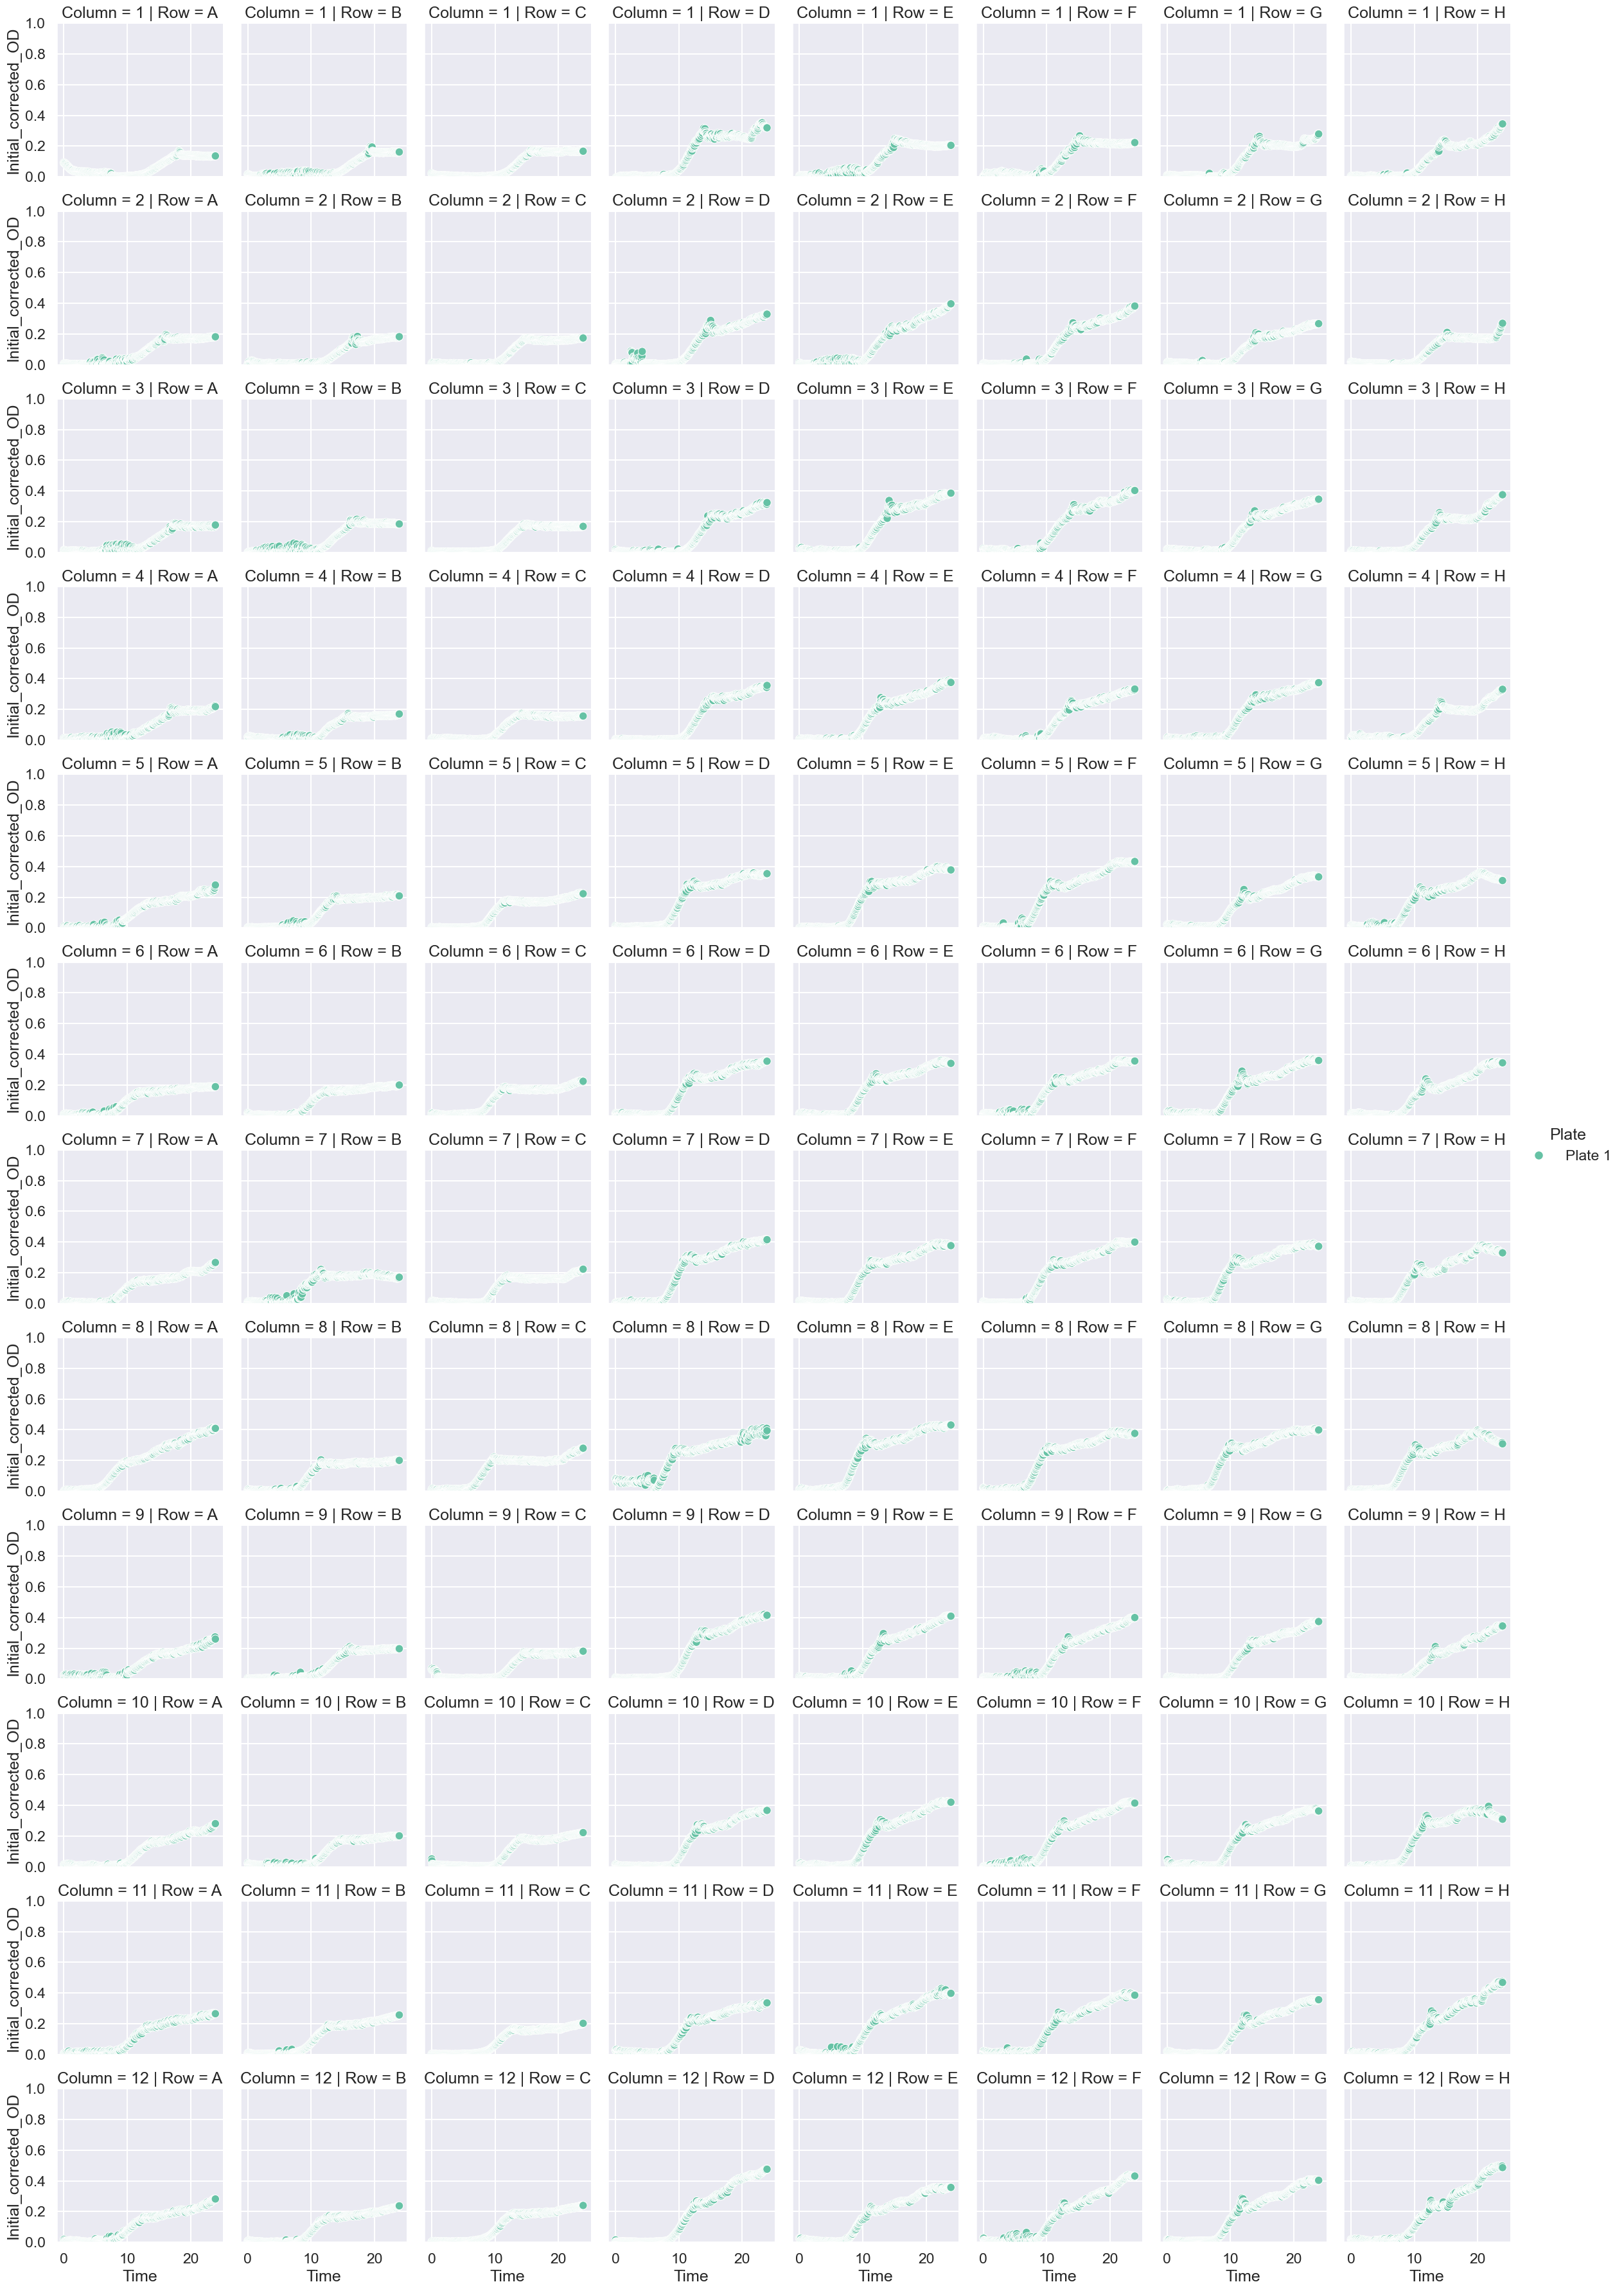

In [5]:
sns.set_context("talk")

sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", col="Row", row="Column", \
            # row="Genotype", 
            height=3, \
            # col_wrap=4,
            data=mdf)

plt.ylim(0,1)

In [6]:
f_mdf = mdf.filter(pl.col("Time") > 1).filter(pl.col("Initial_corrected_OD") > 0)

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_corrected_OD")).log())
    .alias("Log_initial_corrected_OD")
])

f_mdf = f_mdf.with_columns([
    ((pl.col("Initial_median_corrected_OD")).log())
    .alias("Log_initial_median_corrected_OD")
])


f_mdf = f_mdf.filter(pl.col("Log_initial_corrected_OD").is_not_nan())

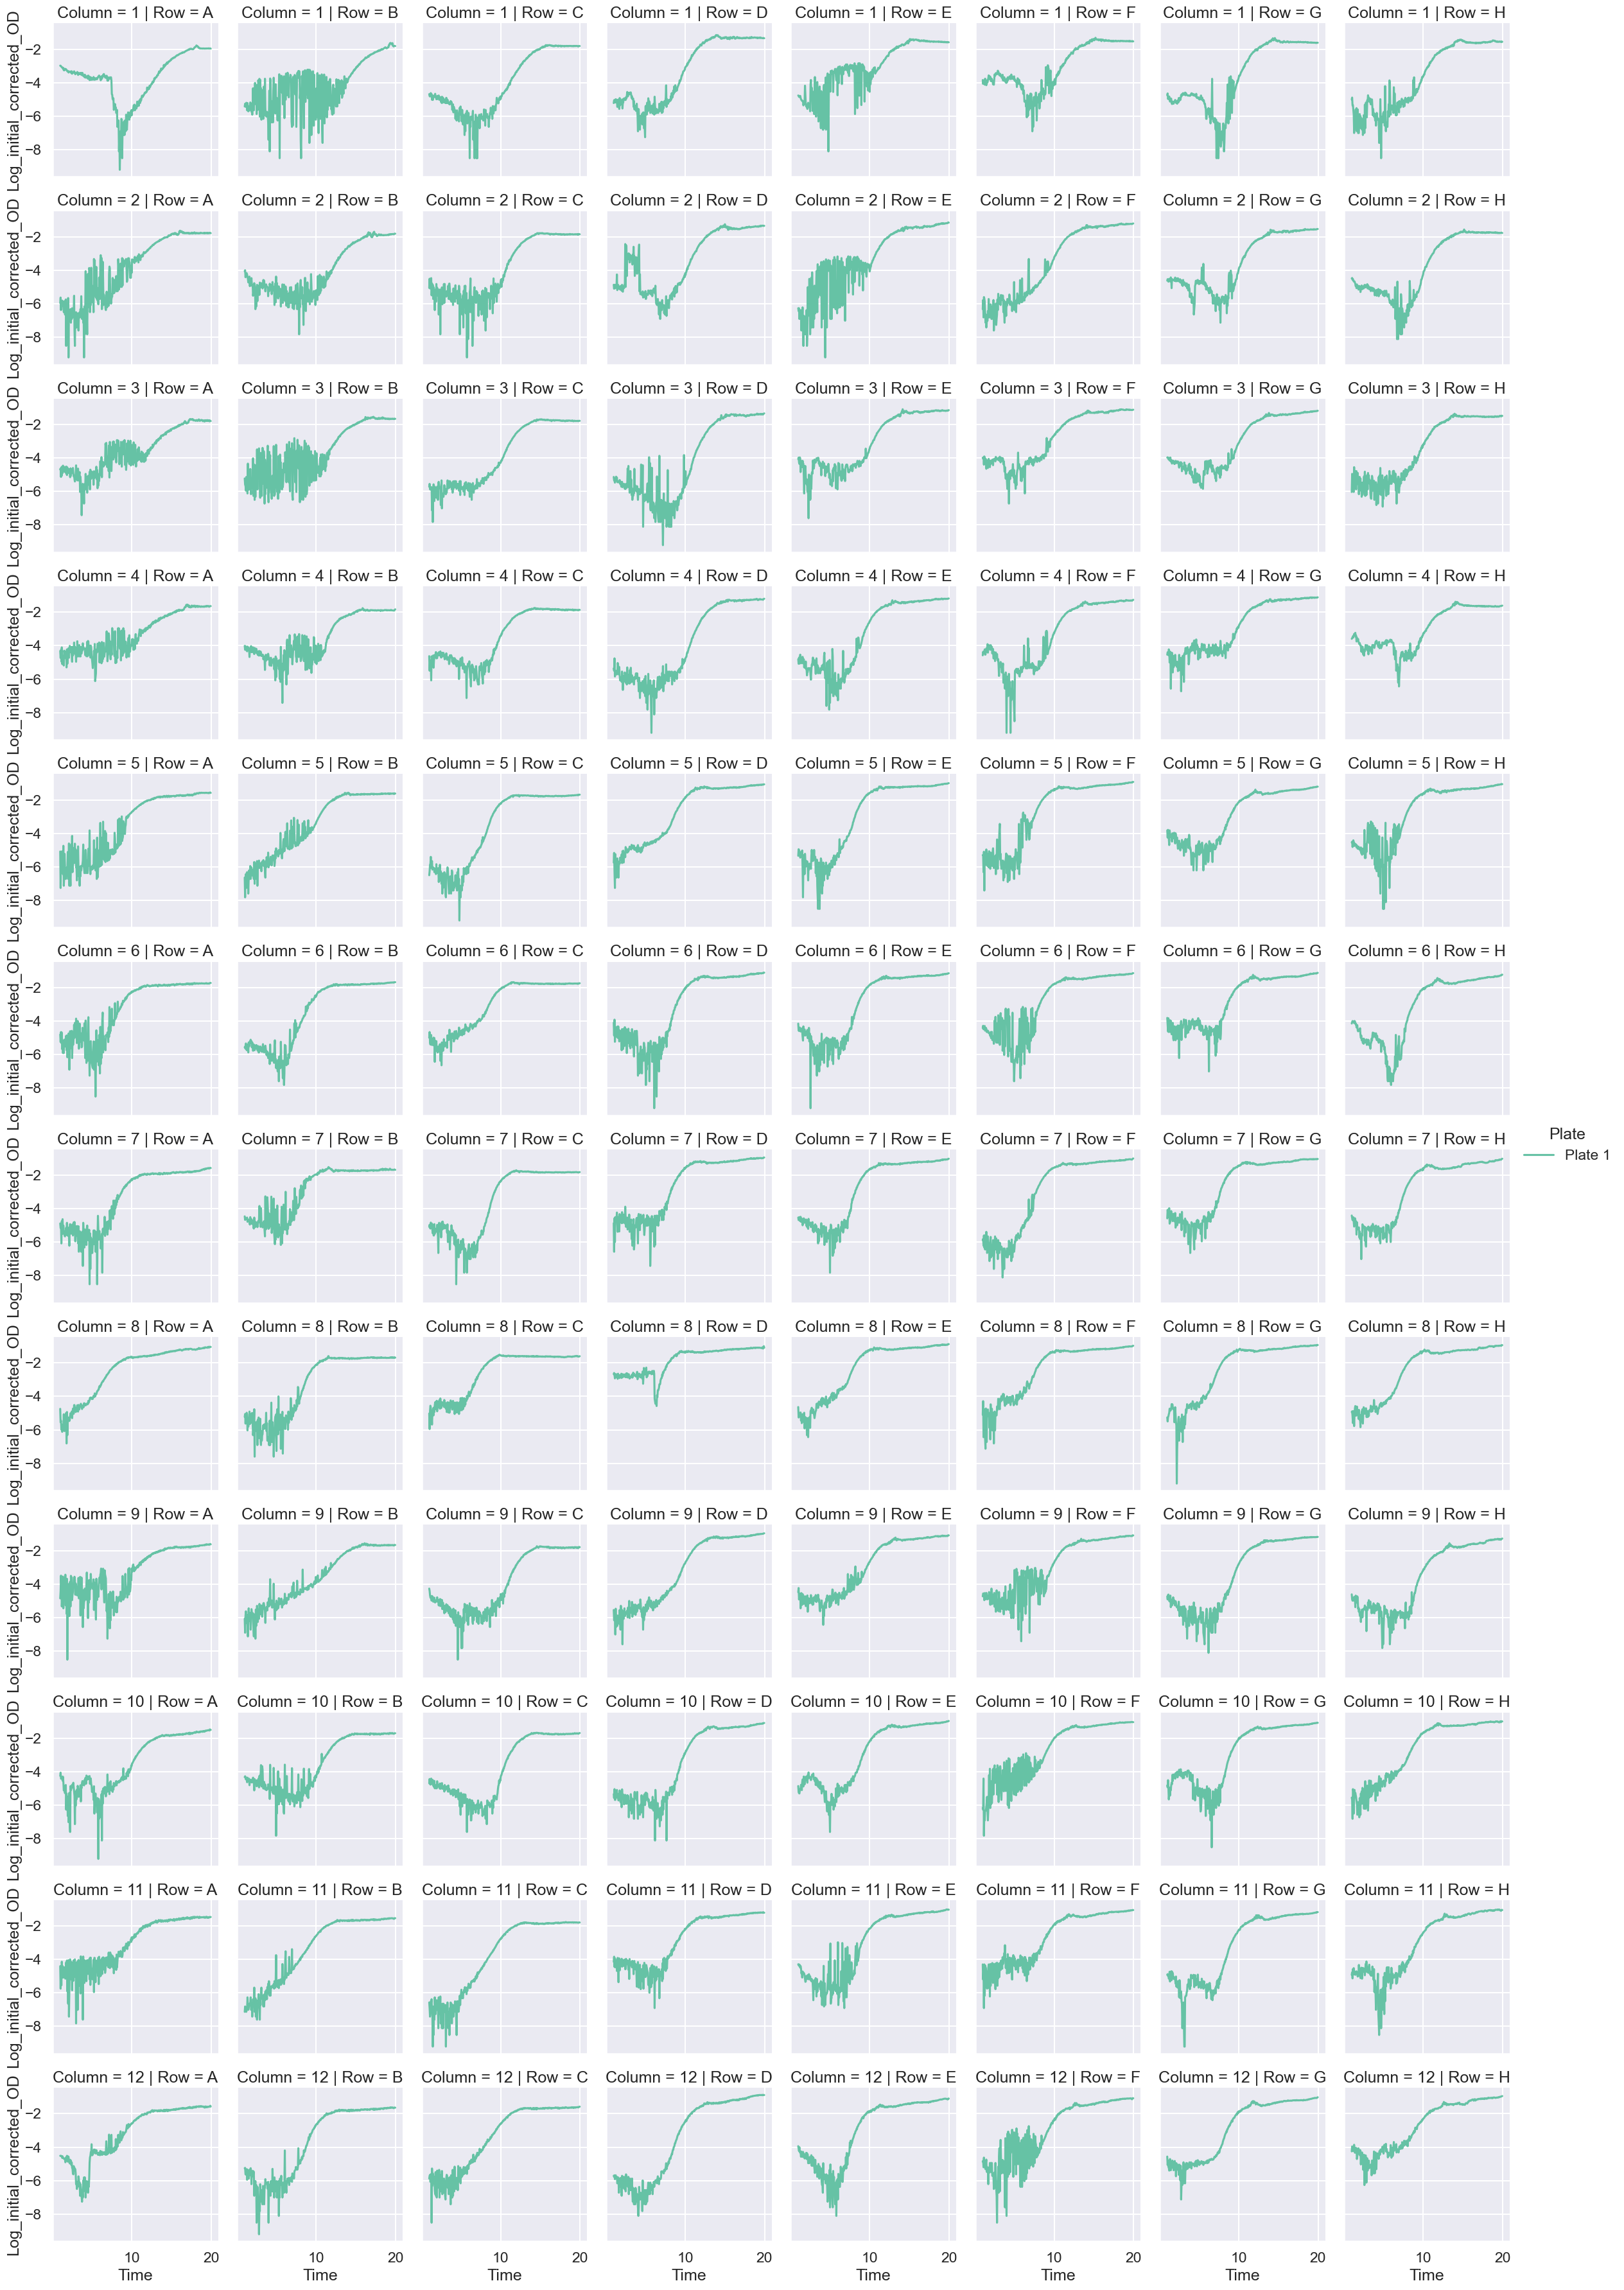

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Column", col="Row", height=3, \
                data=f_mdf.filter(pl.col("Time") < 20))


In [8]:
gr_df = f_mdf.filter( (pl.col("Time") < 20))
minimum_start_times = gr_df.filter(pl.col("Log_initial_corrected_OD") <= -4.).group_by(["Plate", "Well"]).agg(pl.max("Time").alias("Time_exp_start")).sort("Time_exp_start")
minimum_end_times = gr_df.filter(pl.col("Log_initial_corrected_OD") >= -3).group_by(["Plate", "Well"]).agg(pl.min("Time").alias("Time_exp_end")).sort("Time_exp_end")

gr_df = gr_df.join(minimum_start_times, on=["Plate", "Well"])
gr_df = gr_df.join(minimum_end_times, on=["Plate", "Well"])
gr_df = gr_df.filter((pl.col("Time") > pl.col("Time_exp_start")) & (pl.col("Time") < pl.col("Time_exp_end")))
gr_df = gr_df.with_columns((pl.col("Time") - pl.col("Time_exp_start")).alias("Corrected_time"))
gr_df.head(5)

# regress and pick top x 
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()

M = 0
N = 3
top_gr = pl.DataFrame(predicted_gr.sort_values(by=["Genotype", "Additive", "Plate", "slope"], ascending=False).groupby(['Genotype', 'Additive', 'Plate']).nth[M:N])
top_gr.head(7)

gr_df = gr_df.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"])

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_15774/3850865122.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time']).reset_index()


(7.0, 8.0)

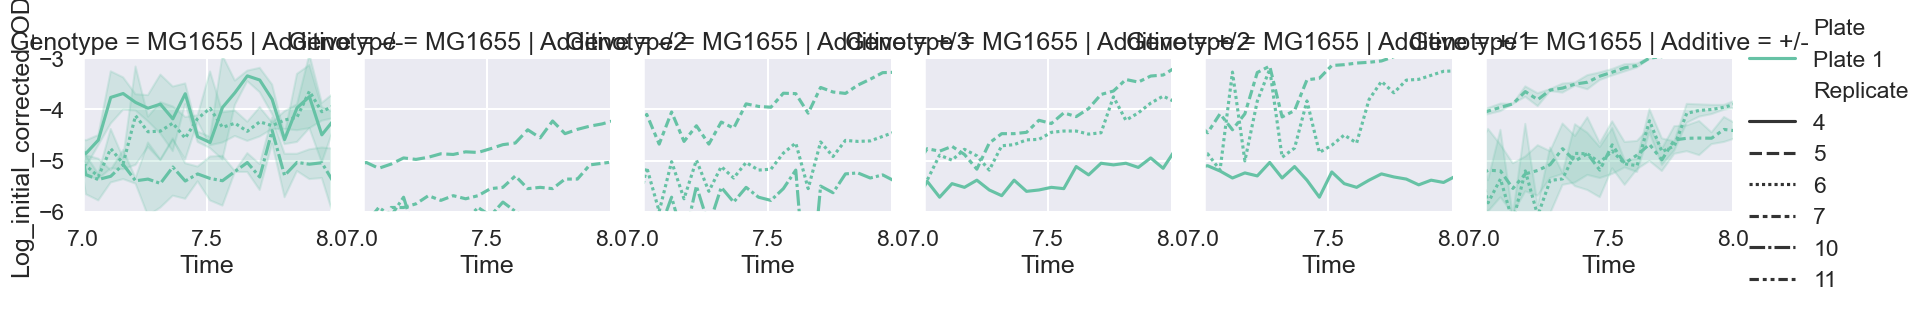

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.relplot(x="Time", y="Log_initial_corrected_OD", hue="Plate", kind="line", row="Genotype", col="Additive", style="Replicate", height=3, \
                data=f_mdf.join(top_gr, on=["Additive", "Plate", "Replicate", "Genotype"]))

plt.ylim(-6,-3)
plt.xlim(7,8)
    
# plt.savefig("weird_plate.png")

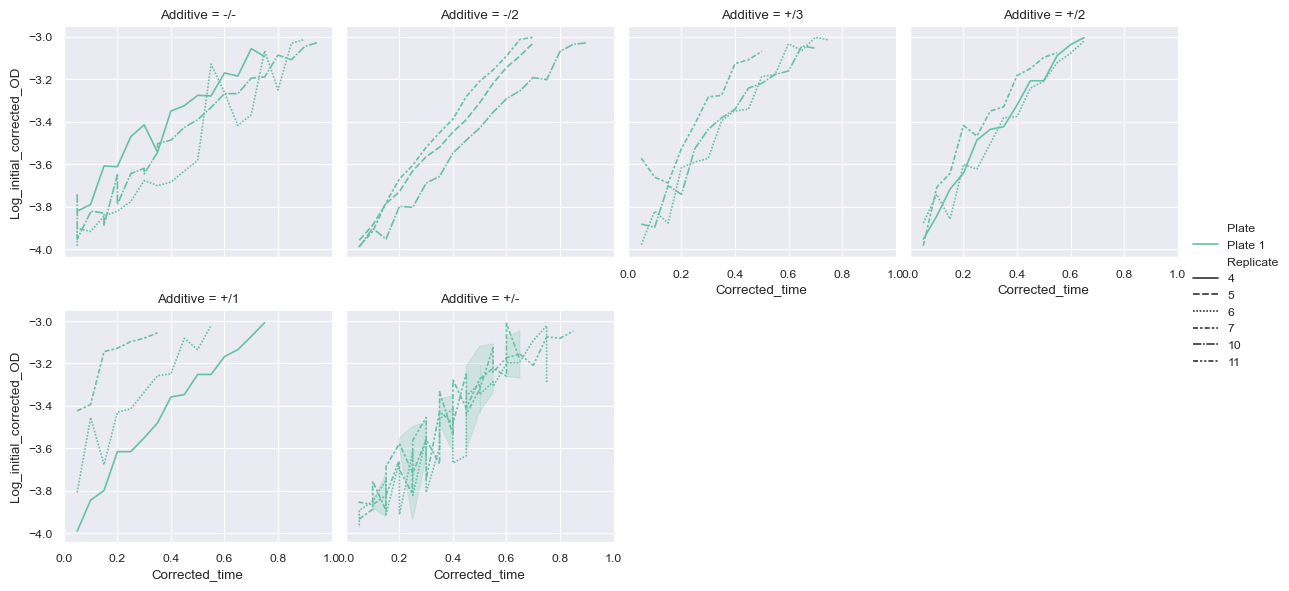

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    sns.set_context("paper")
    sns.relplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Plate", kind="line", col="Additive", style="Replicate", 
                col_wrap=4, 
                # row="Genotype",
                height=3, \
                data=gr_df)
    
    plt.xlim([0,1])

# plt.savefig("plates.png")

(0.0, 3.0)

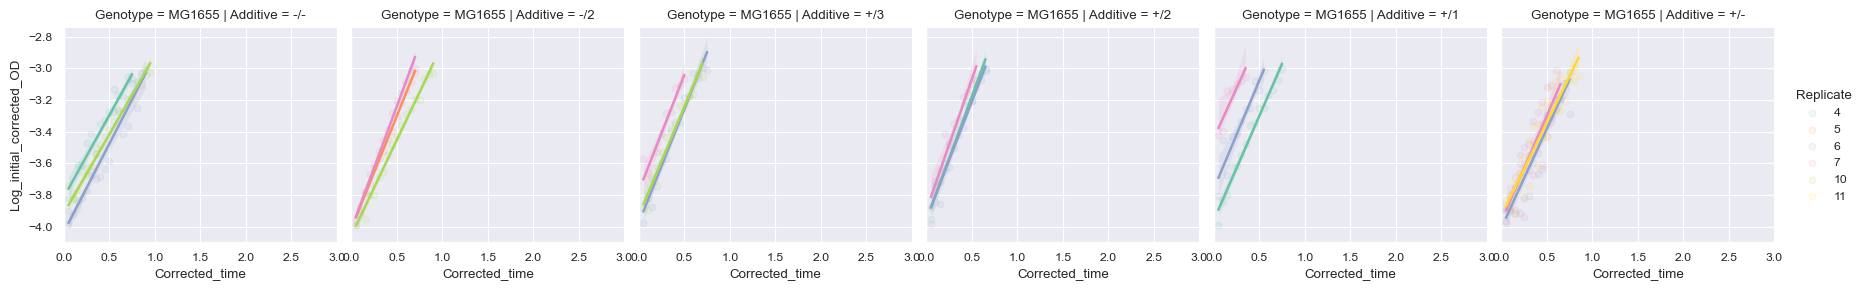

In [11]:
sns.lmplot(x="Corrected_time", y="Log_initial_corrected_OD", hue="Replicate", col="Additive", 
           # col_wrap=4,  \
           row="Genotype",
           height=3,
           data=gr_df.to_pandas(), scatter_kws = {"alpha": 0.1})

plt.xlim([0,3])


In [12]:
# sns.relplot(x="Time", y="Log_initial_corrected_OD", kind="line", row="Replicate", col="Additive", height=3, \
#             data=f_mdf.filter(pl.col("Time") < 15))

In [13]:
# sns.set_context("paper")

# sns.relplot(x="Time", y="Initial_corrected_OD", hue="Plate", style="Replicate", kind="scatter", col="Additive", \
#             # row="Genotype", height=3, \
#             col_wrap=4,
#             data=mdf)

In [14]:
predicted_gr = gr_df \
.to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])
predicted_gr["doubling_time"] = np.log(2) / predicted_gr["slope"]
predicted_gr = predicted_gr.reset_index()


gr_mean_std = predicted_gr.groupby(['Genotype', 'Additive']).agg({'slope':['mean','std']})
gr_mean_std.columns = gr_mean_std.columns.get_level_values(1)
gr_mean_std["doubling_time"] = np.log(2)/gr_mean_std["mean"]
# gr_mean_std = gr_mean_std.reset_index()

predicted_gr["doubling_time"] = np.log(2)/predicted_gr["slope"] * 60
predicted_gr

/var/folders/dx/0239zgvj0tgf46b5h8l7v_fc0000gn/T/ipykernel_15774/4127042248.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .to_pandas().groupby(['Genotype', 'Additive','Replicate', 'Plate']).apply(regress_error, 'Log_initial_corrected_OD', ['Corrected_time'])


,Genotype,Additive,Replicate,Plate,slope,intercept,slope_e,intercept_e,doubling_time
0,MG1655,+/-,6,Plate 1,1.250401,-4.007660,0.084514,0.038411,33.260383
1,MG1655,+/-,7,Plate 1,1.332296,-3.965493,0.160436,0.061491,31.215918
2,MG1655,+/-,11,Plate 1,1.173670,-3.930701,0.087764,0.040876,35.434849
3,MG1655,+/1,4,Plate 1,1.317036,-3.959294,0.057695,0.026228,31.577593
4,MG1655,+/1,6,Plate 1,1.367509,-3.761275,0.167899,0.056937,30.412119
5,MG1655,+/1,7,Plate 1,1.268096,-3.442542,0.281699,0.062990,32.796281
6,MG1655,+/2,4,Plate 1,1.564046,-3.960109,0.069495,0.027580,26.590544
7,MG1655,+/2,6,Plate 1,1.482139,-3.951927,0.079196,0.031430,28.060010
8,MG1655,+/2,7,Plate 1,1.652033,-3.895799,0.163249,0.055360,25.174328
9,MG1655,+/3,6,Plate 1,1.438293,-3.976323,0.082476,0.037482,28.915416


In [15]:
# save dataframe
save_df = pl.DataFrame(predicted_gr)
save_df = save_df.select("Additive", "slope")
save_df = save_df.with_columns(pl.col("Additive").str.split_exact(by="/", n=1).alias("split"))
save_df = save_df.unnest("split").rename({"slope": "Growth rate", "field_0": "Nitrate", "field_1": "Molybdenum"})

save_df.write_csv("no3_df.csv")

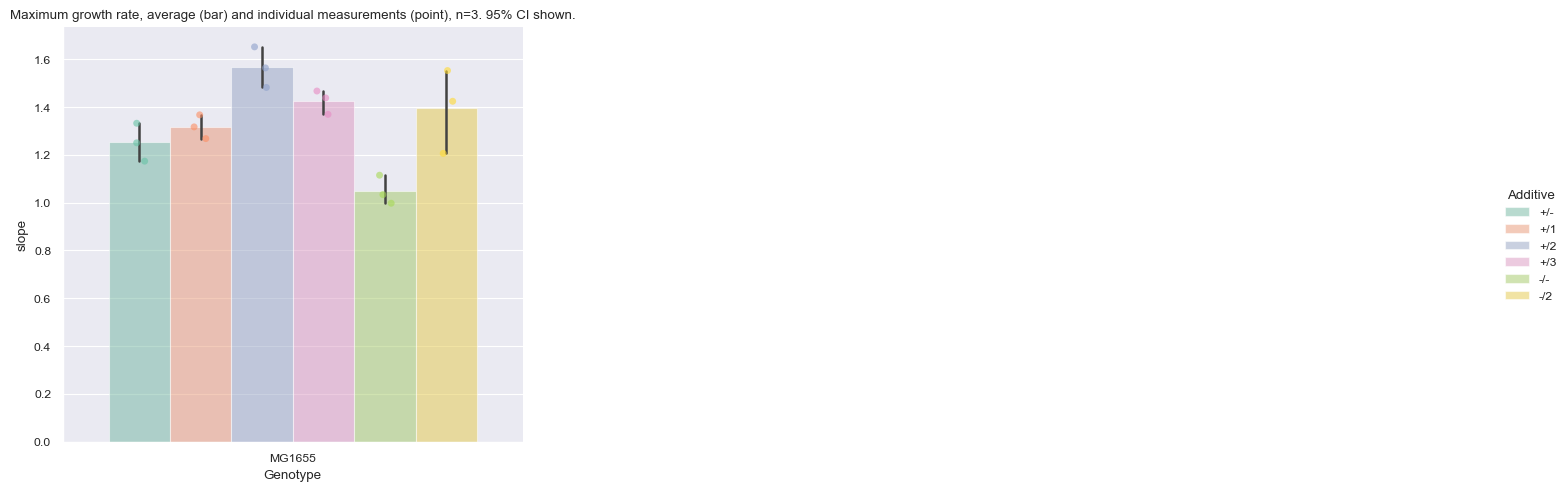

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    filter_df = pl.DataFrame(predicted_gr).filter((pl.col("Genotype") == "MG1655"))
    filter_df.head(5)
    
    g = sns.catplot(x="Genotype", y="slope", hue="Additive", 
                    data=filter_df.to_pandas(), kind="bar",  
                    height=5, aspect=1, alpha=0.5, errorbar="ci",
                    col="Plate", col_wrap=3
                       );
    g.map_dataframe(sns.stripplot, x="Genotype", y="slope", 
                    hue="Additive", palette="Set2",
                    alpha=0.6, dodge=True)
    
    plt.title("Maximum growth rate, average (bar) and individual measurements (point), n=3. 95% CI shown.")
    # plt.ylim([0.8, 1.4])
    
    plt.show()
    
   #  g.savefig("story1.png")